In [1]:
import cv2, os, torch
import numpy as np
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
from fastai.vision.all import *

In [2]:
class FlowerDataset1(Dataset):
    def __init__(self, im_pths, targets, transform = None, target_transform = None):
        self.im_pths = im_pths
        self.targets = targets
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.im_pths)
        
    def __getitem__(self, idx):
        im_pth = self.im_pths[idx]
        image = Image.fromarray(cv2.imread(im_pth))
        label = self.targets[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label
            

Consider a case where we have only 1 image in the dataset

In [3]:
im_pths = ['datasets/image_1.png']
targets = torch.tensor([0])

In [7]:
transform = transforms.Compose([
    transforms.RandomResizedCrop((224, 224), scale = (0.08, 1.0), ratio = (0.85, 1.25)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),])

In [8]:
ds = FlowerDataset1(im_pths, targets, transform=transform)
bs = 16
dl = DataLoader(ds, batch_size = bs, shuffle = True)

X,y = next(iter(dl))
print(X.shape, y.shape) 

torch.Size([1, 3, 224, 224]) torch.Size([1])


0 torch.Size([1, 3, 224, 224])
0 torch.Size([1, 3, 224, 224])
0 torch.Size([1, 3, 224, 224])


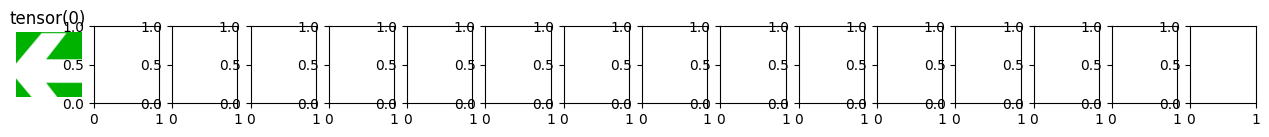

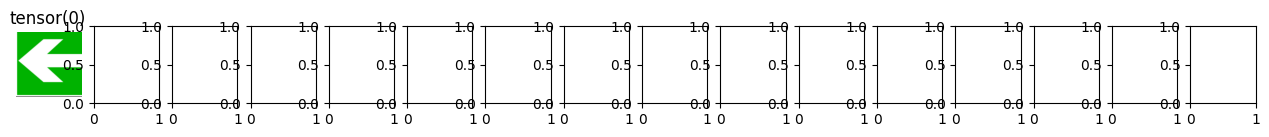

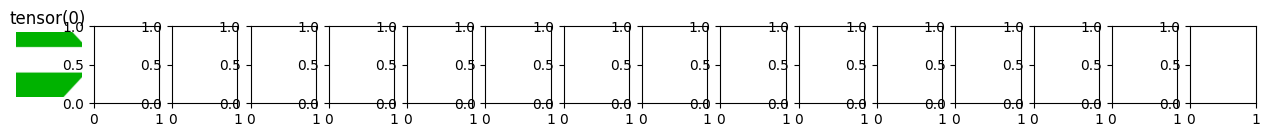

In [9]:
epochs = 3

for epoch in range(epochs):
    for b, (X,y) in enumerate(dl):
        print(b, X.shape)
        X_t = [invTrans(x) for x in X]
        show_image_batch([X_t,y], items=16, cols=16, figsize=(16,1))
    

We can see that the image undergoes transformation every epoch, as we had written in `transform1`. But the number of images don't get changed. The length of entire dataset is still 1. 
Here, the augmentations happen __online__ that is, they are not saved on hard drive and it does not increase the number of images.

There is another way to perform augmentations where suppose we augment to every image say 4 times. Let's see how this can be acheived.

In [10]:
class FlowerDataset2(Dataset):
    ''' To increase the length of dataset with augmentations'''
    def __init__(self, im_pths, targets, num_augmentations, transform = None, target_transform = None):
        self.im_pths = im_pths
        self.targets = targets
        self.num_augmentations = num_augmentations
        self.transform = transform
        self.target_transform = target_transform
        
    def __len__(self):
        return len(self.im_pths)*self.num_augmentations
        
    def __getitem__(self, idx):
        actual_idx = idx // self.num_augmentations
        augmentation_idx = idx % self.num_augmentations
        
        im_pth = self.im_pths[actual_idx]
        image = Image.fromarray(cv2.imread(im_pth))
        label = self.targets[actual_idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

0 torch.Size([8, 3, 224, 224])
0 torch.Size([8, 3, 224, 224])
0 torch.Size([8, 3, 224, 224])


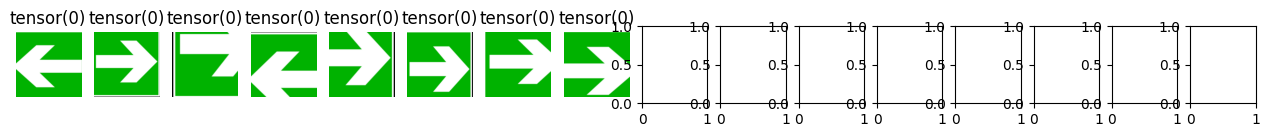

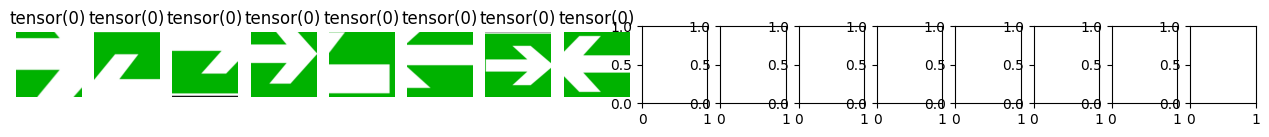

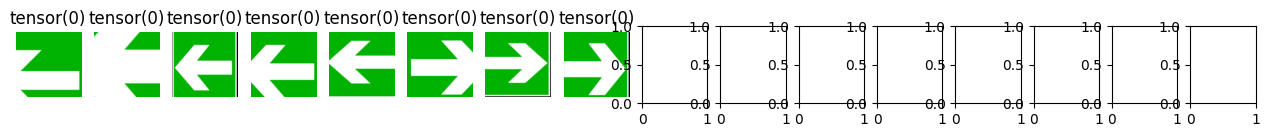

In [11]:
ds = FlowerDataset2(im_pths, targets, num_augmentations=8, transform=transform)
bs = 16
dl = DataLoader(ds, batch_size = bs, shuffle = True)

epochs = 3
for epoch in range(epochs):
    for b, (X,y) in enumerate(dl):
        print(b, X.shape)
        X_t = [invTrans(x) for x in X]
        show_image_batch([X_t,y], items=16, cols=16, figsize=(16,1))
    